## **Step 1: Load and Preprocess the Data**

In [31]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the datasets
feedback_df = pd.read_excel('AI_Engineer_Dataset_Task_1.xlsx')  # Replace with your actual file path
course_info_df = pd.read_excel('AI_Engineer_Dataset_Task_2.xlsx')  # Replace with your actual file path

# Handling missing values (NaNs)
feedback_df = feedback_df.dropna(subset=['ParticipantResponse'])

# Combine course information with feedback based on CourseCode
merged_df = pd.merge(feedback_df, course_info_df, on='CourseCode', how='inner')

# Text preprocessing
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenization and removing stopwords
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

merged_df['CleanedText'] = merged_df['ParticipantResponse'].apply(preprocess_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# **Step 2: Sentiment Analysis**

In [21]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download NLTK's VADER lexicon for sentiment analysis
nltk.download('vader_lexicon')


# Initialize the Sentiment Intensity Analyzer
sia = SentimentIntensityAnalyzer()

# Function to get sentiment and opinion from a text
def get_sentiment_and_opinion(text):
    sentiment = sia.polarity_scores(text)

    # Determine sentiment (positive, negative, neutral)
    if sentiment['compound'] >= 0.05:
        sentiment_label = 'positive'
    elif sentiment['compound'] <= -0.05:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'

    # Extract opinions based on sentiment score
    if sentiment_label == 'positive':
        opinion = 'The student has a positive opinion about the course.'
    elif sentiment_label == 'negative':
        opinion = 'The student has a negative opinion about the course.'
    else:
        opinion = 'The student has a neutral opinion about the course.'

    return sentiment_label, opinion

# Apply sentiment analysis and opinion mining to each feedback comment
merged_df['Sentiment'], merged_df['Opinion'] = zip(*merged_df['CleanedText'].apply(get_sentiment_and_opinion))



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Create Visualizations for Sentiment Distribution


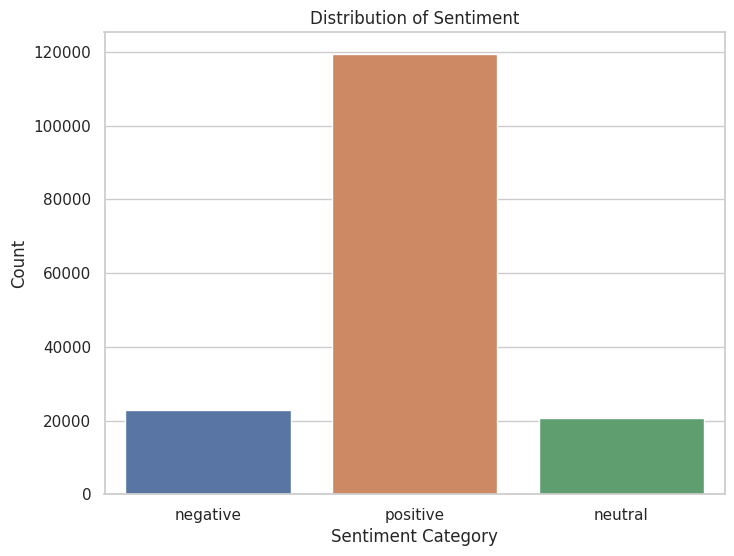

In [18]:
# Create sentiment distribution plot
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, x='Sentiment')
plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.show()

# **Step 4: Topic Modeling**

In [10]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the text data
vectorizer = CountVectorizer(max_df=0.85, min_df=2, max_features=1000)
tf_matrix = vectorizer.fit_transform(merged_df['CleanedText'])

# Apply LDA
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_output = lda_model.fit_transform(tf_matrix)

# Display topics and keywords
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10  # Number of top words per topic
display_topics(lda_model, vectorizer.get_feature_names_out(), no_top_words)


Topic 1:
course good great dr best everything us doctor students amazing
Topic 2:
neutral none na ok hh المناسبة المستحيل لتسهيل الظروف للطالب
Topic 3:
agree strongly كلا hi number showing far take going discussed
Topic 4:
لا في من على المادة شكرا الدكتور thank يوجد المساق
Topic 5:
disagree strongly nil nope 00 showing methods hi كلا far


# **Step 5: Opinion Mining**

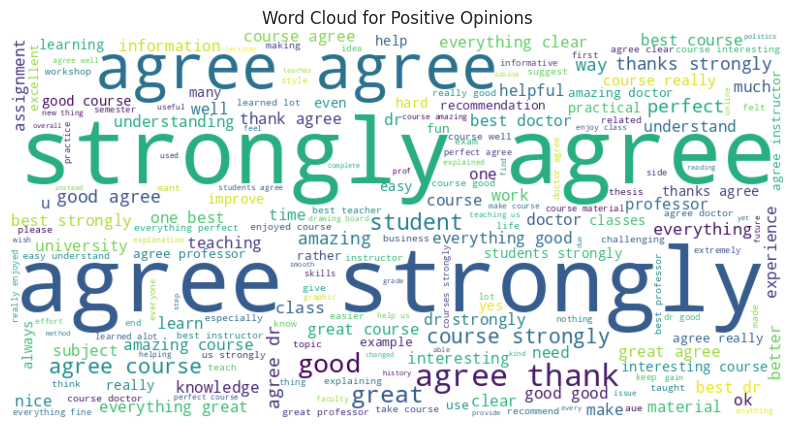

In [20]:
from wordcloud import WordCloud
# Extract opinions by filtering positive sentiment comments
positive_opinions = merged_df[merged_df['Sentiment'] == 'positive']['CleanedText']

# Create a Word Cloud for positive opinions
positive_opinions_text = ' '.join(positive_opinions)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_opinions_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud for Positive Opinions")
plt.show()

## **Step 6: Insights and Recommendations**

In [29]:
# Assuming you have already performed sentiment analysis and topic modeling
# Sentiment Analysis Results
sentiment_counts = merged_df['Sentiment'].value_counts()
positive_count = sentiment_counts['positive']
negative_count = sentiment_counts['negative']
neutral_count = sentiment_counts['neutral']

# Topic Modeling Results

# Insights
insights = []

# Insight 1: Overall Sentiment
if positive_count > negative_count:
    insights.append("Overall sentiment among students is positive.")
else:
    insights.append("Overall sentiment among students is negative.")

# Insight 2: Distribution of Sentiments
insights.append(f"Positive feedback count: {positive_count}")
insights.append(f"Negative feedback count: {negative_count}")
insights.append(f"Neutral feedback count: {neutral_count}")

# Insight 3: Most Common Topics
most_common_topics = lda_output.argmax(axis=1)  # Assuming lda_output contains topic distributions
common_topics_count = pd.Series(most_common_topics).value_counts()
insights.append("Most common topics among feedback:")
for topic, count in common_topics_count.items():
    insights.append(f"Topic {topic + 1}: {count} mentions")

# Insight 4: Specific Sentiment by Course
course_sentiment = merged_df.groupby('CourseName_x')['Sentiment'].value_counts().unstack().fillna(0)
insights.append("Sentiment by Course:")
insights.append(course_sentiment)

# Recommendations
recommendations = []

# Recommendation 1: Improve Negative Areas
if negative_count > 0:
    recommendations.append("Address the issues mentioned in negative feedback to improve the course.")

# Recommendation 2: Enhance Positive Areas
if positive_count > 0:
    recommendations.append("Build upon the positive aspects mentioned in feedback to further enhance the course.")

# Recommendation 3: Focus on Common Topics
if common_topics_count.any():
    recommendations.append("Pay special attention to the common topics mentioned in feedback to meet student needs.")

# Recommendation 4: Course-Specific Actions
for course, row in course_sentiment.iterrows():
    course_recommendation = []  # Store recommendations for each course

    if row['negative'] > 0:
        course_recommendation.append(f"For '{course}', address specific issues mentioned in negative feedback.")

    if row['positive'] > 0:
        course_recommendation.append(f"For '{course}', capitalize on positive feedback to improve further.")

    # Print recommendations only if there are course-specific recommendations
    if course_recommendation:
        recommendations.append("\n".join(course_recommendation))

# Print or save the insights and recommendations
print("Insights:")
for insight in insights:
    if isinstance(insight, pd.DataFrame):
        print(insight)
    else:
        print(f"- {insight}")

print("\nRecommendations:")
for recommendation in recommendations:
    if not recommendation.startswith("For"):
        print(f"- {recommendation}")


Insights:
- Overall sentiment among students is positive.
- Positive feedback count: 119371
- Negative feedback count: 22776
- Neutral feedback count: 20616
- Most common topics among feedback:
- Topic 3: 118120 mentions
- Topic 5: 22726 mentions
- Topic 2: 17085 mentions
- Topic 1: 3551 mentions
- Topic 4: 1281 mentions
- Sentiment by Course:
Sentiment                                           negative  neutral  \
CourseName_x                                                            
2D Animation                                            10.0     17.0   
3D Design                                               61.0     93.0   
Academic Writing                                        52.0     98.0   
Academic Writing 1                                       4.0      3.0   
Accounting Information Systems                          30.0     21.0   
...                                                      ...      ...   
مقدمة في علم تطور الاجناس                               37.0     33.0 

In [30]:
merged_df.to_csv('final_output.csv', index=False)